*This code tests the accuracy and insights of a **logistic regression** on our 4 split datasets (PreSeries, RoundA, RoundB, and RoundC) with their corresponding Y-labels (VGR_PR_to_RA, VGR_RA_to_RB, VGR_RB_to_RC, VGR_RC_to_RD respectively).*

*The Model had good accuracy (~80%) but the insights (which were derived by plotting the coefficients as a bar chart, were inconclusive and misleading)*

In [2]:
#import all neccessary libraries

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import datetime
from datetime import date, timedelta
from scipy import stats
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#read the dataset and see the features
dataset= pd.read_csv('dataset_v6.csv')
dataset.head()

,uuid,name,country_code,state_code,num_funding_rounds,total_funding_usd,num_exits,has_domain,is_company,is_investor,is_school,is_primary_company,is_primary_investor,is_primary_school,is_acquired,is_closed,is_ipo,is_operating,has_facebook,has_linkedin,has_twitter,num_social_media_url_org,has_parent,num_event_appearances_org,num_total_jobs,num_current_jobs,num_male_founder,num_female_founder,num_event_appearances_employee,num_completed_degrees_employee,num_incompleted_degrees_employee,num_completed_degrees_from_top_500_schools,num_incomplete_degrees_from_top_500_schools,num_FAANG_exp_founder,percentage_of_male_founder,acquirer_uuid,acquirer_name,acquirer_country_code,acquirer_state_code,price_usd,is_acquisition_price,has_acquirer,PreSeries_announced_on,RoundA_announced_on,RoundB_announced_on,RoundC_announced_on,RoundD_announced_on,raised_amount_usd,post_money_valuation_usd,investor_count,is_PreSeries,is_RoundA,is_RoundB,is_RoundC,is_RoundD,total_num_top_500_investors,PreSeries_num_top_500_investors,RoundA_num_top_500_investors,RoundB_num_top_500_investors,RoundC_num_top_500_investors,RoundD_num_top_500_investors,PreSeries_investor_count,PreSeries_raised_amount_usd,PreSeries_post_money_valuation_usd,RoundA_investor_count,RoundA_raised_amount_usd,RoundA_post_money_valuation_usd,RoundB_investor_count,RoundB_raised_amount_usd,RoundB_post_money_valuation_usd,RoundC_investor_count,RoundC_raised_amount_usd,RoundC_post_money_valuation_usd,RoundD_investor_count,RoundD_raised_amount_usd,RoundD_post_money_valuation_usd,num_top_500_investors,PreSeries_from_founded,RoundA_from_founded,RoundA_from_PreSeries,RoundB_from_RoundA,RoundB_from_PreSeries,RoundB_from_founded,RoundC_from_RoundB,RoundC_from_RoundA,RoundC_from_PreSeries,RoundC_from_founded,RoundD_from_RoundC,RoundD_from_RoundB,RoundD_from_RoundA,RoundD_from_PreSeries,RoundD_from_founded,stock_symbol,went_public_on,share_price_usd,valuation_price_usd,money_raised_usd,is_share_price_usd,is_valuation_price_usd,is_money_raised_usd,has_date,has_year,year,PreSeries_num_ea_org,RoundA_num_ea_org,RoundB_num_ea_org,RoundC_num_ea_org,RoundD_num_ea_org,is_category_Artificial Intelligence,is_category_Data and Analytics,is_category_Financial Services,is_category_Lending and Investments,is_category_Payments,is_category_Platforms,is_category_Privacy and Security,PreSeries_post_money_valuation_usd_augmented,RoundA_post_money_valuation_usd_augmented,RoundB_post_money_valuation_usd_augmented,RoundC_post_money_valuation_usd_augmented,RoundD_post_money_valuation_usd_augmented,all_time_roi,roi_from_PS_to_RA,roi_from_PS_to_RB,roi_from_PS_to_RC,roi_from_PS_to_RD,roi_from_PS_to_IPO,roi_from_RA_to_RB,roi_from_RA_to_RC,roi_from_RA_to_RD,roi_from_RA_to_IPO,roi_from_RB_to_RC,roi_from_RB_to_RD,roi_from_RB_to_IPO,roi_from_RC_to_RD,roi_from_RC_to_IPO,roi_from_RD_to_IPO,percentage_of_female_founder,PreSeries_from_founded_binned,RoundA_from_founded_binned,RoundB_from_founded_binned,RoundC_from_founded_binned,RoundD_from_founded_binned
0,b528bd22-cce5-c60c-c79a-b4d995f66993,MeetMoi,USA,NY,3.0,5575000.0,0,True,1,0,0,1,0,0,0,0,0,1,0,0,1,1,False,0.0,6.0,3.0,2,0,3.0,5.0,1.0,1.0,0.0,0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,2007-06-01,2008-07-01,2009-09-01,NaN,5575000.0,0.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1500000.0,0.0,1.0,1500000.0,0.0,1.0,2575000.0,0.0,0.0,0.0,0.0,0.0,NaN,151 days,NaN,396 days,NaN,547 days,427 days,823 days,NaN,974 days,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0.0,5.443380e+06,6.629616e+06,1.423062e+07,0.000000e+00,0.531428,NaN,NaN,NaN,NaN,NaN,0.199271,0.531428,NaN,NaN,0.921178,NaN,NaN,NaN,NaN,NaN,0.0,5,0,0,0,5
1,8cb7f859-e757-0937-a18b-e7992c167203,Postini,USA,CA,5.0,26000000.0,0,True,1,0,0,1,0,0,1,0,0,0,0,1,1,2,False,0.0,24.0,4.0,1,0,16.0,15.0,18.0,7.0,13.0,0,1.0,6acfa7da-1dbd-936e-d985-cf07a1b27711,Google,USA,CA,NaN,0.0,1,NaN,NaN,2001-05-09,2002-01-22,2003-09-15,26000000.0,0.0,5.0,0.0,0.0,1.0,1.0,1.0,4.0,0.0,0.0,2.0,1.0,1.

**Dropping non-primary: company entries**

In [4]:
#drop them since other option is 'investor'
dataset= dataset[dataset['is_primary_company']==1]

#convert the boolean columns to bool
dataset['is_PreSeries'] = dataset['is_PreSeries'].astype('bool')
dataset['is_RoundA'] = dataset['is_RoundA'].astype('bool')
dataset['is_RoundB'] = dataset['is_RoundB'].astype('bool')
dataset['is_RoundC'] = dataset['is_RoundC'].astype('bool')
dataset['is_RoundD'] = dataset['is_RoundD'].astype('bool')

#take a look at the top 5 countries from where startups arise
top_countries = dataset['country_code'].value_counts().drop('Unknown').nlargest(5)
top_countries = top_countries.index
top_usa_states = dataset['state_code'].value_counts().drop('Unknown').nlargest(5)
top_usa_states = top_usa_states.index

In [5]:
#fill missing values
dataset['percentage_of_male_founder']= dataset['percentage_of_male_founder'].fillna(0)
dataset['percentage_of_female_founder']= dataset['percentage_of_female_founder'].fillna(0)
dataset['PreSeries_num_ea_org']= dataset['PreSeries_num_ea_org'].fillna(0)
dataset['RoundA_num_ea_org']= dataset['RoundA_num_ea_org'].fillna(0)
dataset['RoundB_num_ea_org']= dataset['RoundA_num_ea_org'].fillna(0)
dataset['RoundC_num_ea_org']= dataset['RoundA_num_ea_org'].fillna(0)
dataset['RoundD_num_ea_org']= dataset['RoundA_num_ea_org'].fillna(0)

**Splitting dataset into 4 datasets with different models: PreSeries, RoundA, RoundB, RoundC**

In [6]:
#The dataset is split in the following manner:
# For PreSeries: take data that has both PreSeries and RoundA, then use all the preseries data to train the model, with target being VGR over PreSeries and RoundA
# Similiary for the other 3 datasets

PreSeries_dataset = dataset[dataset['is_RoundA'] & dataset['is_PreSeries']].copy()
RoundA_dataset = dataset[dataset['is_RoundA'] & dataset['is_RoundB']].copy()
RoundB_dataset = dataset[dataset['is_RoundB'] & dataset['is_RoundC']].copy()
RoundC_dataset = dataset[dataset['is_RoundC'] & dataset['is_RoundD']].copy()

PreSeries_dataset = PreSeries_dataset[PreSeries_dataset['roi_from_PS_to_RA'].notnull()] # there are instances where no dates/no evaluation available -> cant calculate roi
RoundA_dataset = RoundA_dataset[RoundA_dataset['roi_from_RA_to_RB'].notnull()]
RoundB_dataset = RoundB_dataset[RoundB_dataset['roi_from_RB_to_RC'].notnull()]
RoundC_dataset = RoundC_dataset[RoundC_dataset['roi_from_RC_to_RD'].notnull()]

In [7]:
#PreSeries_dataset

**Define Success metric**

In [8]:
#Since logistic regression is binary, we set the threshold to 10%, hence if a compnay has a VGR of above 10%, we classify it as successful

threshold = .1

In [9]:
# identify 'successful' if ROI > threshold (10%)
PreSeries_dataset['is_above_roi_threshold'] = PreSeries_dataset['roi_from_PS_to_RA'] > threshold
RoundA_dataset['is_above_roi_threshold'] = RoundA_dataset['roi_from_RA_to_RB'] > threshold
RoundB_dataset['is_above_roi_threshold'] = RoundB_dataset['roi_from_RB_to_RC'] > threshold
RoundC_dataset['is_above_roi_threshold'] = RoundC_dataset['roi_from_RC_to_RD'] > threshold

In [10]:
#There are certain common features across the 4 datasets, and then dataset-specific features, which we select to train model in different stages

common_features = [
#  'country_code',
#  'state_code',
 'has_domain',
 'is_company',
 'is_investor',
 'is_school',
#  'has_facebook',
#  'has_linkedin',
#  'has_twitter',
 'num_social_media_url_org',
#  'num_event_appearances_org',
#  'num_male_founder',
#  'num_female_founder',
#  'num_event_appearances_employee',
 'num_completed_degrees_employee',
 'num_incompleted_degrees_employee',
 'num_completed_degrees_from_top_500_schools',
 'num_incomplete_degrees_from_top_500_schools',
 'num_FAANG_exp_founder',
 'percentage_of_male_founder',
 'percentage_of_female_founder',
    
 'is_category_Artificial Intelligence',
 'is_category_Data and Analytics',
 'is_category_Financial Services',
 'is_category_Lending and Investments',
 'is_category_Payments',
 'is_category_Platforms',
 'is_category_Privacy and Security',
]

PS_features = [    
 'is_PreSeries',
 'PreSeries_investor_count',
 'PreSeries_num_ea_org',
 'PreSeries_post_money_valuation_usd_augmented']    

RA_features = [
 'is_RoundA',
 'RoundA_investor_count',
 'RoundA_raised_amount_usd',
 'RoundA_num_ea_org',    
 'RoundA_post_money_valuation_usd_augmented']

RB_features = [
 'is_RoundB',
 'RoundB_investor_count',
 'RoundB_raised_amount_usd',
 'RoundB_post_money_valuation_usd',
 'RoundB_num_ea_org',    
 'RoundB_post_money_valuation_usd_augmented']

RC_features = [    
 'is_RoundC',
 'RoundC_investor_count',
 'RoundC_raised_amount_usd',
 'RoundC_post_money_valuation_usd',
 'RoundC_num_ea_org',    
 'RoundC_post_money_valuation_usd_augmented']

RD_features = [    
 'is_RoundD',
 'RoundD_investor_count',
 'RoundD_raised_amount_usd',
 'RoundD_post_money_valuation_usd',
 'RoundD_num_ea_org',
 'RoundD_post_money_valuation_usd_augmented',]

In [11]:
model = LogisticRegression(solver='liblinear', random_state=0)

**PreSeries_dataset**

In [12]:
#Use common features and PS_features to train--> X_Label
# Use VGR between PreSeries and RA --> Y_label

x_features = common_features + PS_features
Y = PreSeries_dataset['is_above_roi_threshold']
X = PreSeries_dataset[x_features]

*Train Model*

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.25, random_state=0)

In [24]:
#standardize the X outputs, since it will skew the Logistic regression model
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)

In [25]:
#Run the model
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

*Evaluate Model*

In [26]:
X_val = scaler.transform(X_val)

In [27]:
y_pred = model.predict(X_val)

In [28]:
#Score of training set

model.score(X_train, y_train)

0.8529616724738676

In [29]:
#Score of Validation (or testing) set

model.score(X_val, y_val)

0.8589341692789969

In [30]:
names= X.columns
names= names.to_numpy(names)
#names

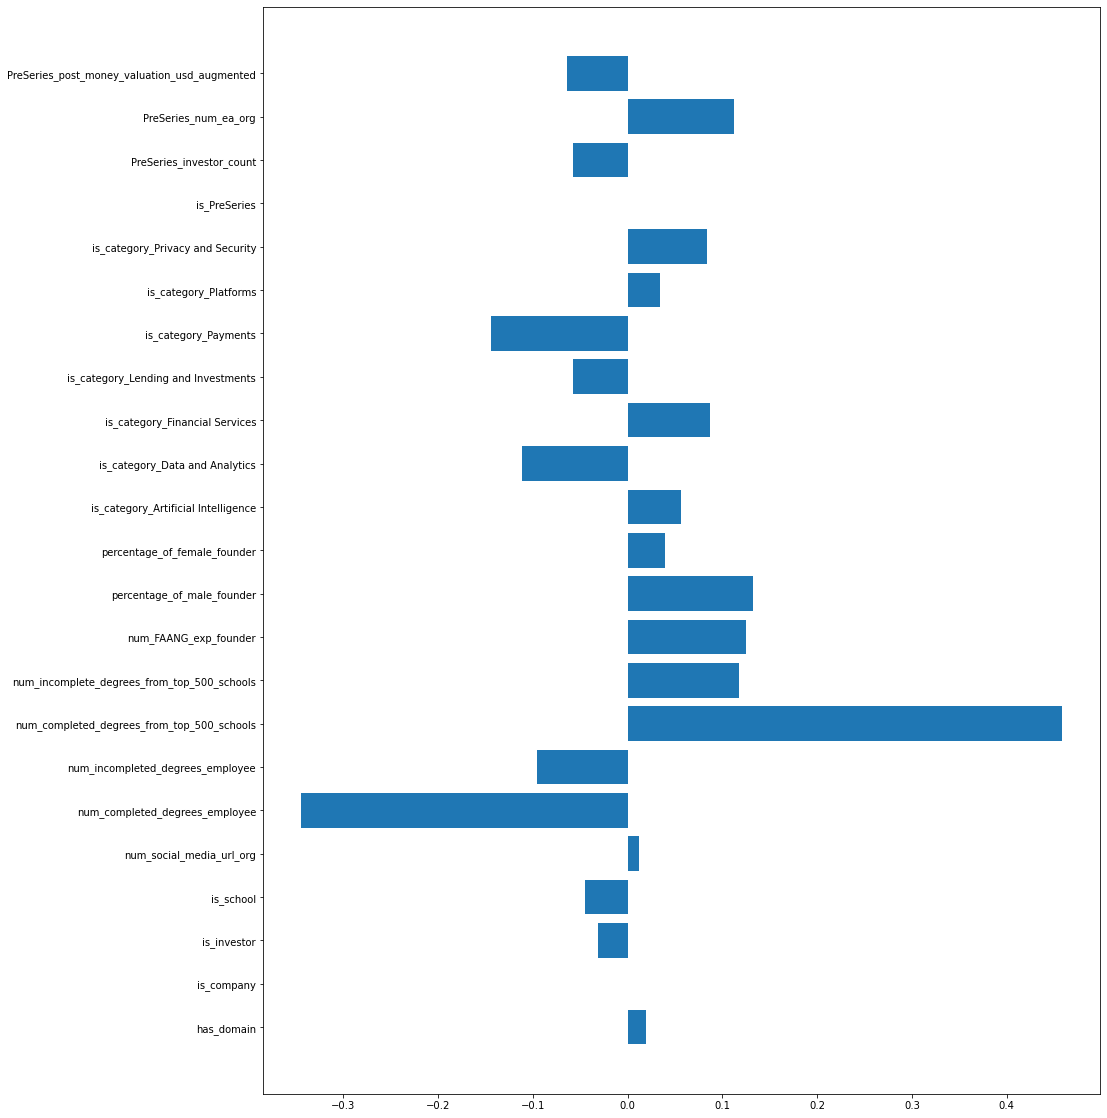

In [31]:
#Plot the coefficients of all the features as bar charts to see the insights


plt.rcParams['figure.figsize'] = (15, 20)
importance = model.coef_[0]
# summarize feature importance
#for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh([x for x in range(len(importance))], importance)
plt.yticks(np.arange(X.shape[1]),names)
plt.show()

In [33]:
#See classification report to see the accuracy and F1 score

print(classification_report(y_val, y_pred)) #Accuracy = 86%

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       135
        True       0.86      1.00      0.92       822

    accuracy                           0.86       957
   macro avg       0.43      0.50      0.46       957
weighted avg       0.74      0.86      0.79       957



**SeriesA_dataset**

In [34]:
#Use common features, PS_features, and RA_features to train--> X_Label
# Use VGR between RA and RB --> Y_label

x_features = common_features + PS_features + RA_features 
Y_a = RoundA_dataset['is_above_roi_threshold']
X_a = RoundA_dataset[x_features]

*Train Model*

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_a, Y_a, test_size = 0.25, random_state=0)

In [36]:
#standardize the X outputs, since it will skew the Logistic regression model
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)

In [38]:
#Run the model
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

*Evaluate Model*

In [39]:
X_val = scaler.transform(X_val)

In [40]:
y_pred = model.predict(X_val)

In [41]:
#Score of the Training set
model.score(X_train, y_train)

0.8763693270735524

In [43]:
#Score of the validation (or test) set
model.score(X_val, y_val)

0.8732394366197183

In [44]:
names= X_a.columns
names= names.to_numpy(names)
#names

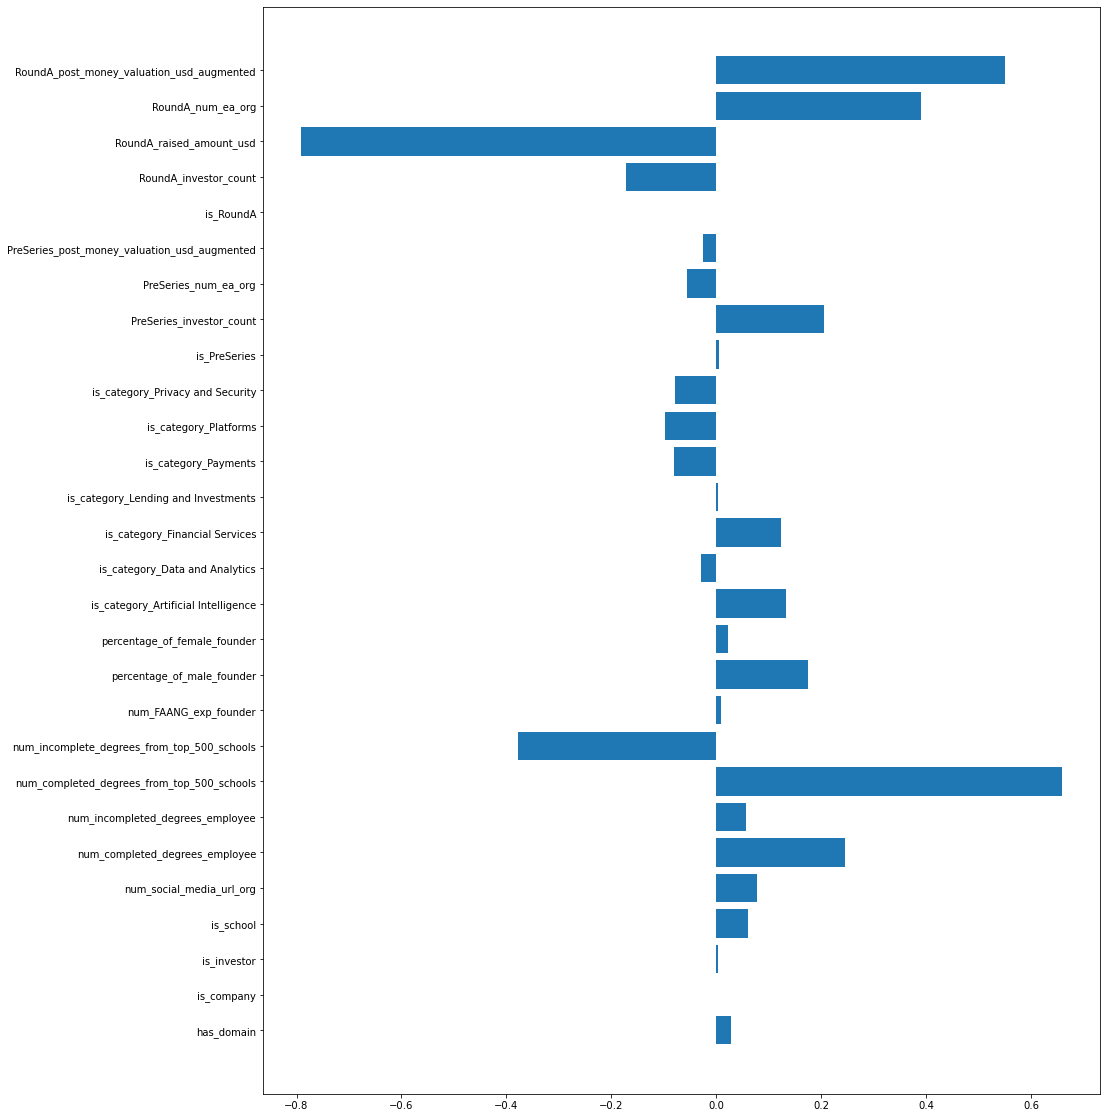

In [45]:
#Plot the coefficients of all the features as bar charts to see the insights

plt.rcParams['figure.figsize'] = (15, 20)
importance = model.coef_[0]
# summarize feature importance
#for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh([x for x in range(len(importance))], importance)
plt.yticks(np.arange(X_a.shape[1]),names)
plt.show()

In [46]:
print(classification_report(y_val, y_pred)) #Accuracy of 88%

              precision    recall  f1-score   support

       False       0.33      0.02      0.04       106
        True       0.88      0.99      0.93       746

    accuracy                           0.87       852
   macro avg       0.61      0.51      0.48       852
weighted avg       0.81      0.87      0.82       852



**SeriesB_dataset**

In [53]:
#Use common features, PS_features, RA_features, and RB_Features to train--> X_Label
# Use VGR between RB and RC --> Y_label

x_features = common_features + PS_features + RA_features + RB_features 
Y_b = RoundB_dataset['is_above_roi_threshold']
X_b = RoundB_dataset[x_features]

*Train Model*

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_b, Y_b, test_size = 0.25, random_state=0)

In [55]:
#standardize the X outputs, else it will skew the results
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)

In [56]:
#Run the model
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

*Evaluate Model*

In [57]:
X_val = scaler.transform(X_val)

In [58]:
y_pred = model.predict(X_val)

In [59]:
#Score of the training set
model.score(X_train, y_train)

0.8033157498116051

In [61]:
#Score of the validation (or test) set
model.score(X_val, y_val)

0.7787810383747178

In [62]:
names= X_b.columns
names= names.to_numpy(names)
#names

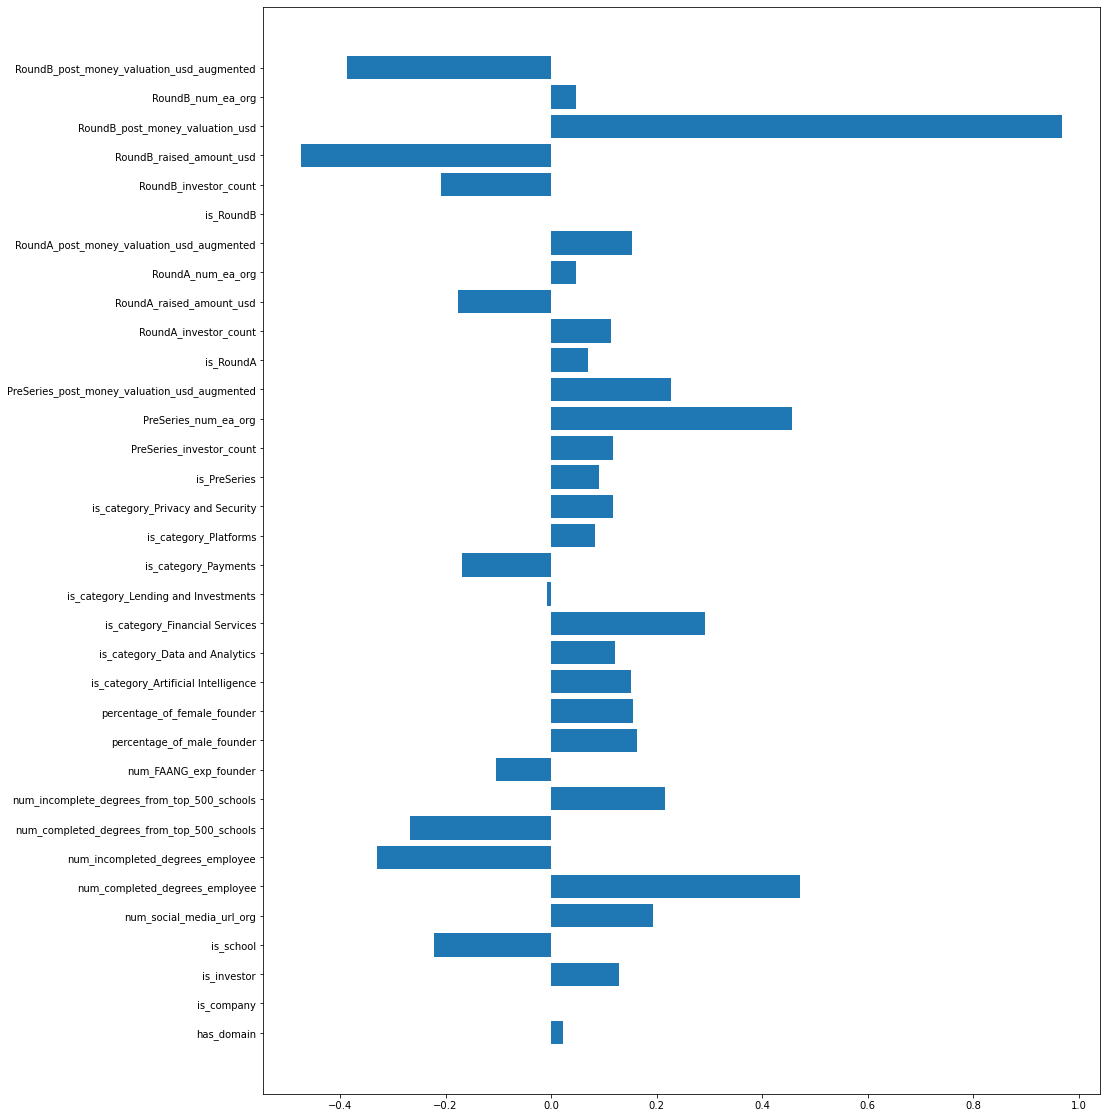

In [63]:
#Plot the coefficients of all the features as bar charts to see the insights

plt.rcParams['figure.figsize'] = (15, 20)
importance = model.coef_[0]
# summarize feature importance
#for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh([x for x in range(len(importance))], importance)
plt.yticks(np.arange(X_b.shape[1]),names)
plt.show()

In [65]:
print(classification_report(y_val, y_pred))  #Accuracy of 78%

              precision    recall  f1-score   support

       False       0.67      0.02      0.04        99
        True       0.78      1.00      0.88       344

    accuracy                           0.78       443
   macro avg       0.72      0.51      0.46       443
weighted avg       0.75      0.78      0.69       443



**SeriesC_dataset**

In [66]:
#Use common features, PS_features, RA_features, RB_Features, and RC_Features to train--> X_Label
# Use VGR between RC and RD --> Y_label

x_features = common_features + PS_features + RA_features + RB_features + RC_features
Y_c = RoundC_dataset['is_above_roi_threshold']
X_c = RoundC_dataset[x_features]

*Train Model*

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_c, Y_c, test_size = 0.25, random_state=0)

In [68]:
#standardize the X outputs, else it will skew the results of the logistic regression
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)

In [69]:
#Run the model
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

*Evaluate Model*

In [70]:
X_val = scaler.transform(X_val)

In [71]:
y_pred = model.predict(X_val)

In [72]:
#Score of the training set
model.score(X_train, y_train)

0.6550951847704367

In [74]:
#Score of the validation (or test) set
model.score(X_val, y_val)

0.6208053691275168

In [75]:
names= X_c.columns
names= names.to_numpy(names)
#names

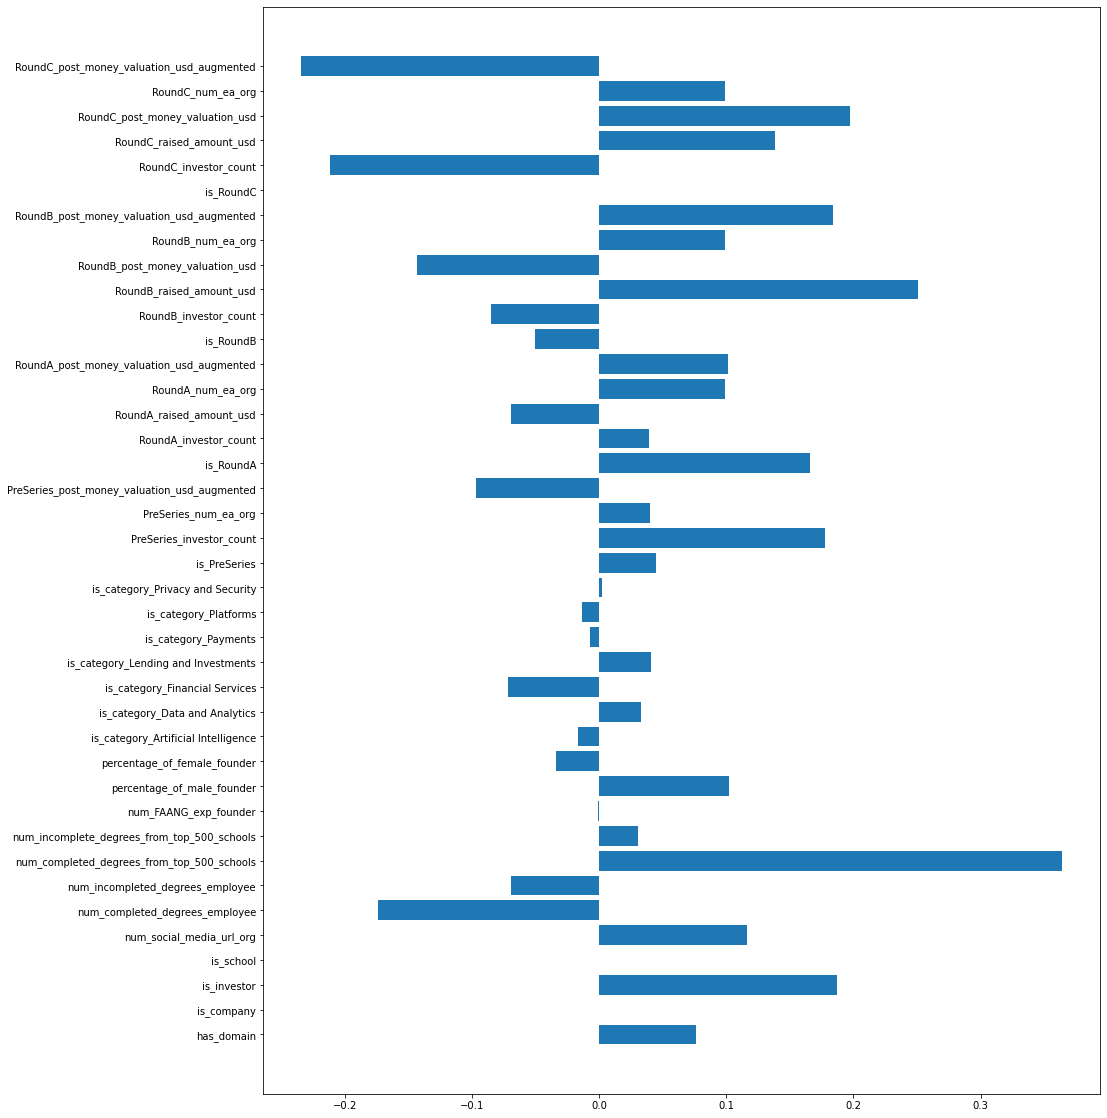

In [76]:
#Plot the coefficients of all the features as bar charts to see the insights

plt.rcParams['figure.figsize'] = (15, 20)
importance = model.coef_[0]
# summarize feature importance
#for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh([x for x in range(len(importance))], importance)
plt.yticks(np.arange(X_c.shape[1]),names)
plt.show()

In [77]:
print(classification_report(y_val, y_pred)) #accuracy of 62%

              precision    recall  f1-score   support

       False       0.43      0.12      0.19       109
        True       0.64      0.91      0.75       189

    accuracy                           0.62       298
   macro avg       0.54      0.51      0.47       298
weighted avg       0.57      0.62      0.55       298

